# **Riyadh's Coffee Shops**

In this project, built a classifier model to predict the quality of coffee shops **'Overall'** based on the reviews and another features.


The dataset include details about [Riyadh's coffee shops](https://www.kaggle.com/mohammedhalosaimi/riyadh-coffee-shops), like address, number of rating, rating, price, ..etc.


**This project include two model:**
- In first model used reviews to predict 'Overall'. 
- In second model used another features to predict 'Overall'.



In [423]:
import pandas as pd

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer # to create Bag of words
from sklearn.model_selection import train_test_split  # for splitting data
from sklearn.linear_model import LogisticRegression # to bulid classifier model
from sklearn.preprocessing import LabelEncoder # to convert classes to number 
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix # to calculate accuracy and classification report

# NLP libraries
import re # for preprocessing text
import string # for preprocessing text
import nltk # for processing texts
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords # list of stop words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [417]:
# to change text style 
class style:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### **Load dataset**

In [375]:
df = pd.read_csv('riyad_coffee_shops_clean.csv')

In [376]:
df.head()

,Unnamed: 0,shop_name,rating,numbers_of_rating,price,shop_type,key_words,address,reviews
0,0,Elixir Bunn Coffee,4.3,218,0,cafe,none,"King Abdullah Rd, حي الحمراء، Riyadh 13215",['Amazing new branch for my favorite coffee ho...
1,1,Chamonix Cafe,4.0,563,3,coffee shop,"Late-night food, Breakfast, Outdoor seating","9259 Wadi Al Awsat, Al nbsp;2430, Riyadh",['Its really romantic and lovely place with go...
2,2,dr.CAFE COFFEE,4.1,1571,2,coffee shop,"Cosy, Casual, Vegetarian options","As Sulimaniyah, Khurais Road Abi Al Arab Stree...","[""Sandwich wasn't tasty and it was expensive. ..."
3,3,The Shaky,3.9,52,0,coffee shop,"Cosy, Casual, Groups",لوكاليزر مول بوابة رقم 7 طريق الأمير محمد بن ع...,"['Nice place', ""It's delicious you can build y..."
4,4,قرمز كافيه - قهوة مختصة,4.1,956,2,coffee shop,"Cosy, Casual, Groups",2659 Dammam Branch Road Al Yarmuk Riyadh 13243...,['This coffee shop is a two story shop with a ...


In [377]:
df.shape

(198, 9)

### **Explore data**

#### **Split key_words**

In [378]:
# find unique key words from dataset
keys = [i.split(', ') for i in df.key_words]
keys = list({x for l in keys for x in l})[1:] # remove 'None' key word

In [379]:
# split key_words to many columns

dic_keys = dict((key, []) for key in keys) # add unique key words as key for dict

# itrate through key_words column 
for i in df.key_words:
  for k in keys:
    # store 1 if key existing in the cureent key_word row, otherwise, store 0
    matched_keys = [dic_keys[k].append(1) if k in i.split(', ')  else dic_keys[k].append(0)]

In [380]:
# join new columns in the data
df = df.join(pd.DataFrame(dic_keys))
df.head()

,Unnamed: 0,shop_name,rating,numbers_of_rating,price,shop_type,key_words,address,reviews,Breakfast,Cash only,Vegetarian options,Cosy,Late-night food,Casual,Outdoor seating,Groups,Happy hour food,Good for kids
0,0,Elixir Bunn Coffee,4.3,218,0,cafe,none,"King Abdullah Rd, حي الحمراء، Riyadh 13215",['Amazing new branch for my favorite coffee ho...,0,0,0,0,0,0,0,0,0,0
1,1,Chamonix Cafe,4.0,563,3,coffee shop,"Late-night food, Breakfast, Outdoor seating","9259 Wadi Al Awsat, Al nbsp;2430, Riyadh",['Its really romantic and lovely place with go...,1,0,0,0,1,0,1,0,0,0
2,2,dr.CAFE COFFEE,4.1,1571,2,coffee shop,"Cosy, Casual, Vegetarian options","As Sulimaniyah, Khurais Road Abi Al Arab Stree...","[""Sandwich wasn't tasty and it was expensive. ...",0,0,1,1,0,1,0,0,0,0
3,3,The Shaky,3.9,52,0,coffee shop,"Cosy, Casual, Groups",لوكاليزر مول بوابة رقم 7 طريق الأمير محمد بن ع...,"['Nice place', ""It's delicious you can build y...",0,0,0,1,0,1,0,1,0,0
4,4,قرمز كافيه - قهوة مختصة,4.1,956,2,coffee shop,"Cosy, Casual, Groups",2659 Dammam Branch Road Al Yarmuk Riyadh 13243...,['This coffee shop is a two story shop with a ...,0,0,0,1,0,1,0,1,0,0


In [381]:
# convert shop_type to numeric 
# 'cafe' = 0 , 'coffee shop' =1
df.shop_type = [0 if i == 'cafe' else 1 for i in df.shop_type]

#### **Create Target** 

In [382]:
## Add target column
df['overall'] = ['Good' if i > 4 else 'Bad' for i in df.rating]

In [383]:
# split reviews for the same coffee shop
reviews = []
for i in range(len(df)):
  reviews_per_coffee_shop = str(df.loc[i].reviews).replace('"',"'").split("', '")
  for j in range(len(reviews_per_coffee_shop)):
    # add review and overall to the reviews list
    reviews.append([reviews_per_coffee_shop[j],df.loc[i].overall]) 

In [384]:
# create new dataframe for reviews 
reviews_df = pd.DataFrame.from_records(reviews, columns=['Review','Class'])
reviews_df.sample(3)

,Review,Class
468,['I've only tried the hot chocolate and it's g...,Good
167,Best place to have coffee..best ever Coffee Latte,Bad
491,['(Translated by Google) The place is better t...,Good


In [385]:
reviews_df.shape

(562, 2)

#### **Clean data**

In [386]:
def clean_text(text):
  '''
  DESCRIPTION:
  This function to preproccesing text 

  INPUT: 
  text: string

  OUTPUT: 
  text: string after clean it

  ''' 
  text = text.lower() # convert letters to lower case
  text = re.sub("[^a-zA-Z]", " ", text) # remove non-letters
  text = re.sub(r'\d+', '', text) # remove number
  text = re.sub(r'http\S+', '', text) # remove links
  text = text.translate(str.maketrans('','', string.punctuation)) # remove punctuation
  text = re.sub(' +', ' ',text) # remove extra space
  text = text.strip() # remove whitespaces

  text = ' '.join([word for word in text.split() if word not in stopwords.words("english")]) # remove stop words

  # lemmatization returns an actual word of the language
  lemma = nltk.WordNetLemmatizer() # define lemmatizer
  text = ' '.join([lemma.lemmatize(word) for word in text.split()]) 

  #ps = PorterStemmer() # define stemmer
  #text = ' '.join([ps.stem(word) for word in text.split()]) 

  
  return text

In [387]:
# The cleaning function applied in all reviews
reviews_df['Cleaned_Review'] = reviews_df['Review'].apply(clean_text)

In [388]:
# get the empty reviews after cleaning procces 
empty_reviews_index = reviews_df[reviews_df.Cleaned_Review == ''].index
print("There are ",len(empty_reviews_index),' empty reviews in the data.')

# drop these rows 
reviews_df.drop(empty_reviews_index, inplace= True)

There are  7  empty reviews in the data.


## **Baseline**

In [389]:
# baseline model
reviews_df.Class.value_counts(normalize=True)

Bad     0.556757
Good    0.443243
Name: Class, dtype: float64

## **Text Classifiction model**

### **Data prepration**

#### **Create a bag of words (CountVectorizer)**

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) use to convert a collection of text documents to a matrix of token counts.


In [390]:
max_features = 100 # maximum number of features 
count_vector = CountVectorizer(max_features = max_features)  # create Count Vectorizer
X = count_vector.fit_transform(reviews_df['Cleaned_Review']).toarray() # fit the CountVectorizer using reviews data
X

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [391]:
print("Most using {} words: {} ".format(max_features, count_vector.get_feature_names()))

most using 100 words: ['also', 'always', 'amazing', 'area', 'atmosphere', 'available', 'average', 'bad', 'beautiful', 'best', 'branch', 'cafe', 'cake', 'chair', 'chocolate', 'clean', 'coffee', 'cold', 'come', 'comfortable', 'cozy', 'cup', 'customer', 'day', 'decoration', 'definitely', 'delicious', 'dessert', 'drink', 'enjoy', 'espresso', 'ever', 'excellent', 'family', 'favorite', 'food', 'friend', 'friendly', 'get', 'go', 'good', 'google', 'great', 'high', 'hot', 'however', 'inside', 'latte', 'like', 'little', 'location', 'lot', 'love', 'make', 'many', 'meeting', 'menu', 'morning', 'music', 'need', 'new', 'nice', 'one', 'option', 'order', 'ordered', 'original', 'outdoor', 'perfect', 'place', 'price', 'quality', 'quiet', 'quite', 'really', 'recommend', 'riyadh', 'seating', 'service', 'shop', 'sit', 'small', 'staff', 'starbucks', 'sweet', 'table', 'taste', 'tasty', 'time', 'translated', 'tried', 'try', 'two', 'variety', 'visit', 'way', 'well', 'white', 'work', 'would'] 


In [392]:
# counts for each word in count_vector
print(count_vector.vocabulary_)

{'amazing': 2, 'new': 60, 'branch': 10, 'favorite': 34, 'coffee': 16, 'like': 48, 'cafe': 11, 'drink': 28, 'cold': 17, 'good': 40, 'nice': 61, 'staff': 82, 'also': 0, 'work': 98, 'excellent': 32, 'cup': 21, 'morning': 57, 'really': 74, 'place': 69, 'food': 35, 'enjoy': 29, 'little': 49, 'friendly': 37, 'price': 70, 'come': 18, 'great': 42, 'service': 78, 'tasty': 87, 'friend': 36, 'comfortable': 19, 'decoration': 24, 'one': 62, 'shop': 79, 'riyadh': 76, 'variety': 93, 'hot': 44, 'cake': 12, 'delicious': 26, 'translated': 89, 'google': 41, 'small': 81, 'original': 66, 'two': 92, 'area': 3, 'family': 33, 'ordered': 65, 'time': 88, 'go': 39, 'atmosphere': 4, 'best': 9, 'bad': 7, 'beautiful': 8, 'latte': 47, 'dessert': 27, 'white': 97, 'option': 63, 'get': 38, 'try': 91, 'sweet': 84, 'many': 54, 'customer': 22, 'taste': 86, 'espresso': 30, 'tried': 90, 'seating': 77, 'visit': 94, 'day': 23, 'need': 59, 'quiet': 72, 'well': 96, 'music': 58, 'quite': 73, 'location': 50, 'lot': 51, 'clean': 1

In [393]:
d = pd.DataFrame(X,columns=count_vector.get_feature_names())
d

,also,always,amazing,area,atmosphere,available,average,bad,beautiful,best,branch,cafe,cake,chair,chocolate,clean,coffee,cold,come,comfortable,cozy,cup,customer,day,decoration,definitely,delicious,dessert,drink,enjoy,espresso,ever,excellent,family,favorite,food,friend,friendly,get,go,...,new,nice,one,option,order,ordered,original,outdoor,perfect,place,price,quality,quiet,quite,really,recommend,riyadh,seating,service,shop,sit,small,staff,starbucks,sweet,table,taste,tasty,time,translated,tried,try,two,variety,visit,way,well,white,work,would
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
551,2,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,4,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,0,0,0,0
552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### **Split data to train and test**

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X,reviews_df['Class'], test_size =0.2, random_state=42)

### **Logistic Regression**

In [409]:
# Define Logistic Regression
model = LogisticRegression()

# train model
model.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### **Results**

In [430]:
# Predicting the Train set results 
print('Train model accuracy: ',accuracy_score(y_train, model.predict(X_train)))

Train model accuracy:  0.7094594594594594


In [410]:
# Predicting the Test set results 
y_pred = model.predict(X_test) 
print('Test model accuracy: ',accuracy_score(y_test, y_pred))

Test model accuracy:  0.6396396396396397


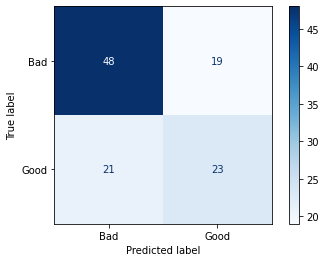

In [426]:
plot_confusion_matrix(model, X=X_test, y_true=y_test, cmap='Blues');

In [422]:
print(style.BOLD,"Predict 'Overall'using reviews",style.END)
print("The classification report for Logistic Regression model")
print('-------------------------------------------------------\n')
print(classification_report(y_test, y_pred))

 Predict 'Overall'using reviews 
The classification report for Logistic Regression model
-------------------------------------------------------

              precision    recall  f1-score   support

         Bad       0.70      0.72      0.71        67
        Good       0.55      0.52      0.53        44

    accuracy                           0.64       111
   macro avg       0.62      0.62      0.62       111
weighted avg       0.64      0.64      0.64       111



## **Overall predict using features**

#### **Split data to train and test**

In [400]:
X_ = df[['numbers_of_rating', 'price','shop_type','Breakfast',
       'Cash only', 'Vegetarian options', 'Cosy', 'Late-night food', 'Casual',
       'Outdoor seating', 'Groups', 'Happy hour food', 'Good for kids']]

y_ = df['overall']

In [403]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_, test_size =0.2, random_state=42)


### **Logistic Regression**

In [405]:
# Define Logistic Regression
model_ = LogisticRegression()

# train model
model_.fit(X_train_, y_train_) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### **Results**

In [432]:
# Predicting the Train set results 
print('Train model accuracy: ',accuracy_score(y_train_, model_.predict(X_train_)))

Train model accuracy:  0.5949367088607594


In [406]:
# Predicting the Test set results 
y_pred_ = model_.predict(X_test_) 
print('Test model accuracy: ',accuracy_score(y_test_, y_pred_))

Test model accuracy:  0.625


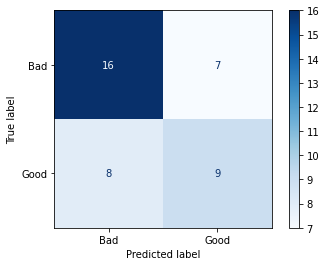

In [425]:
plot_confusion_matrix(model_, X=X_test_, y_true=y_test_, cmap='Blues');

In [421]:
print(style.BOLD,"Predict 'Overall'using features",style.END)
print("The classification report for Logistic Regression model")
print('-------------------------------------------------------\n')
print(classification_report(y_test_, y_pred_))

 Predict 'Overall'using features 
The classification report for Logistic Regression model
-------------------------------------------------------

              precision    recall  f1-score   support

         Bad       0.67      0.70      0.68        23
        Good       0.56      0.53      0.55        17

    accuracy                           0.62        40
   macro avg       0.61      0.61      0.61        40
weighted avg       0.62      0.62      0.62        40



## **Conclusion**

As see in the above results, both model are classify the data well. There is many ways to improvement the results, such as:
- Increase dataset.
- Add more features.
- Apply differant techniques for texts vectoriztion.